In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

In [2]:



#input_dir = 'bootstrap-toy-study8a-1d-1d-nominal-resolution'
#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution-5k-toys'
#input_dir = 'simple-pdf-toy-study6b-1d-1a'




#input_dir = 'hist-pdf-toy-study-1d-1a-perfect'
#input_dir = 'hist-pdf-toy-study-1d-1a-goodres'
#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution'
#input_dir = 'hist-pdf-toy-study-1d-1b-mediumbad'

input_dir = 'hist-pdf-toy-study-1d-1b-read-points-nominal-resolution'


#input_dir = 'bootstrap-toy-study8a-1d-1d-perfect'
#input_dir = 'bootstrap-toy-study8a-1d-1d'
#input_dir = 'bootstrap-toy-study8a-1d-1d-nominal-resolution'
#input_dir = 'bootstrap-toy-study8a-1d-1d-gpu0'



#weights_file = 'omnifold-output-weights.npy'

weights_file = 'bootstrap-weights-003.npy'


with open( '%s/train-and-true-samples.npy' % input_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)
    
print('\n\n')
print(' shape of train_pts:  %s' % str(train_pts.shape))
print(' shape of true_pts:   %s' % str(true_pts.shape))
print('\n\n')






 shape of train_pts:  (100000, 1)
 shape of true_pts:   (10000, 1)





In [3]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [4]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)

with open( '%s/config-pars.npy' % input_dir, 'rb') as f :
    train_mu = np.load(f, allow_pickle=True )
    train_rho = np.load(f, allow_pickle=True)
    train_sig = np.load(f, allow_pickle=True)    
    true_mu = np.load(f, allow_pickle=True )
    true_rho = np.load(f, allow_pickle=True)
    true_sig = np.load(f, allow_pickle=True)  
    resolution = np.load(f, allow_pickle=True)
    train_cov = np.load(f, allow_pickle=True)
    true_cov = np.load(f, allow_pickle=True)



 Number of feature dimensions: 1




In [5]:
with open( "%s/%s" % (input_dir, weights_file),'rb') as f :
    omnifold_weights = np.load(f)


In [6]:
omnifold_weights

array([0.09604334, 0.10739119, 0.10262409, ..., 0.12534732, 0.12273081,
       0.10435996])

In [7]:
train_cov_inv = np.linalg.inv( train_cov )
true_cov_inv = np.linalg.inv( true_cov )

train_pts_minus_train_mu = train_pts - train_mu
train_pts_minus_true_mu = train_pts - true_mu

true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

norm2_true = np.power( 3.14159265, ndim) * true_cov_det
norm2_train = np.power( 3.14159265, ndim) * train_cov_det

pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)

pdf_ratio = pdf_true / pdf_train

sample_sf = (1.*len(true_pts))/(1.*len(train_pts))

calc_weight = pdf_ratio
calc_weight_scaled = sample_sf * pdf_ratio


In [8]:
calc_weight_scaled

array([0.09427797, 0.10903639, 0.10247616, ..., 0.12336848, 0.12334703,
       0.10481374])

<function matplotlib.pyplot.show(close=None, block=None)>

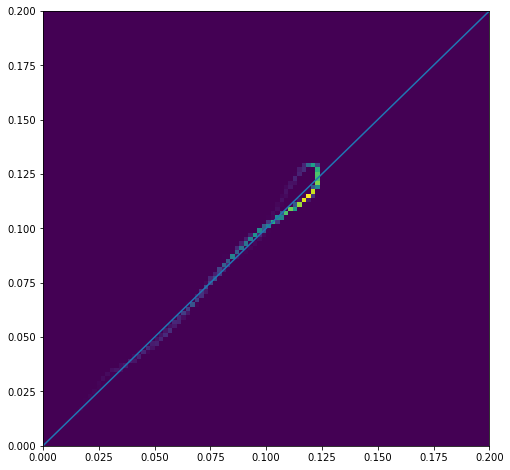

In [9]:
fig,ax = plt.subplots( 1, 1, figsize=(8,8))

max_weight = 0.2
ax.hist2d( calc_weight_scaled, omnifold_weights, 
          bins=[100,100], range=([0,max_weight],[0,max_weight]))
ax.plot([0,max_weight],[0,max_weight])
plt.show

In [10]:
train_pts[:,0]

array([-0.46336226,  0.02393367, -0.20724547, ...,  1.12523375,
        0.97045159, -0.12846198])

<function matplotlib.pyplot.show(close=None, block=None)>

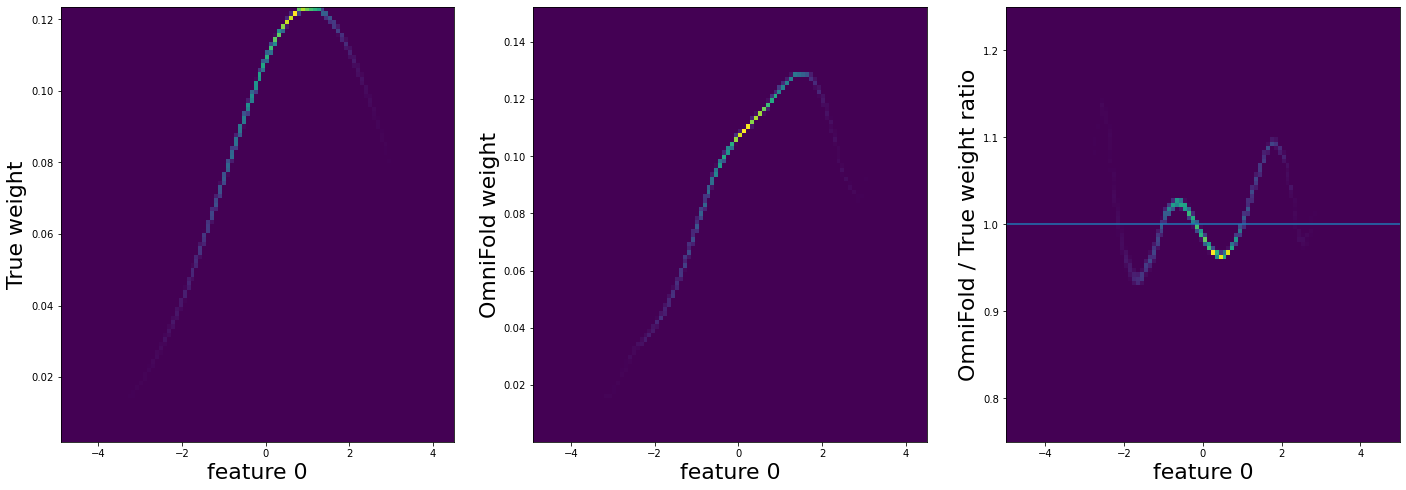

In [11]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,8))

ax[0].hist2d( train_pts[:,0], calc_weight_scaled, bins=[100,100])
ax[1].hist2d( train_pts[:,0], omnifold_weights, bins=[100,100])
ax[2].hist2d( train_pts[:,0], omnifold_weights/calc_weight_scaled, 
             bins=[100,100], range=([-5,5],[0.75,1.25]))
ax[2].plot([-5,5],[1.,1.])


ax[0].set_ylabel('True weight', fontsize=22)
ax[1].set_ylabel('OmniFold weight', fontsize=22)
ax[2].set_ylabel('OmniFold / True weight ratio', fontsize=22)

ax[0].set_xlabel('feature 0', fontsize=22)
ax[1].set_xlabel('feature 0', fontsize=22)
ax[2].set_xlabel('feature 0', fontsize=22)


plt.show